In [1]:
import random
import pandas as pd
import numpy as np
import os
import cv2
import copy

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torchvision import transforms as T
from torchsummary import summary

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import warnings
import util
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay

warnings.filterwarnings(action='ignore')

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [2]:
CFG = {
    'IMG_SIZE':380,
    'EPOCHS':4,
    'LEARNING_RATE':5e-5,
    'BATCH_SIZE':12,
    'SEED':41,
    'OUTLIER_RATIO': 0.05
}

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

In [3]:
class BaseModel(nn.Module):
    def __init__(self, num_classes=5):
        super(BaseModel, self).__init__()
        self.backbone = models.efficientnet_b4(pretrained=True)
        self.backbone.classifier[-2] = nn.Dropout(0.7)
        self.backbone.classifier[-1] = nn.Linear(1792, num_classes)
        
    def forward(self, x):
        x = self.backbone(x)
        return x

In [4]:
class CustomDataset(Dataset):
    def __init__(self, path_list, label_list, tfms):
        self.path_list = path_list
        self.label_list = label_list
        self.tfms = tfms
        
    def __getitem__(self, index):
        image = cv2.imread(self.path_list[index])
        if self.tfms is not None:
            image = self.tfms(image = image)['image']

        if self.label_list is not None:
            label = np.zeros(5)
            label[int(self.label_list[index][0])] = 1
            label[3 + int(self.label_list[index][1])] = 1
            label = np.float32(label)
            return image, label
        else:
            return image
        
    def __len__(self):
        return len(self.path_list)

In [5]:
def train(model, optimizer, epochs, train_loader, val_loader, scheduler, device, alpha = 0):
    model.to(device)
    criterion = nn.BCELoss().to(device)
    val_score = None
    
    for epoch in range(1, epochs+1):
        model.train()
        train_loss = []
        for imgs, labels in tqdm(iter(train_loader)):
            #라벨 스무딩 적용
            if alpha != 0:
                labels[:, :3] = labels[:, :3] - labels[:, :3] * alpha + torch.ones(labels[:, :3].shape) * alpha / 3
                labels[:, 3:] = labels[:, 3:] - labels[:, 3:] * alpha + torch.ones(labels[:, 3:].shape) * alpha / 2
            imgs = imgs.float().to(device)
            labels = labels.float().to(device)
            optimizer.zero_grad()
            
            output = model(imgs)
            output = torch.concat([F.softmax(output[:, :3]), F.softmax(output[:, 3:])], dim=1)
            loss = criterion(output, target=labels)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())

        if val_loader == None:
            print(f'Train Loss : [{np.mean(train_loss):.5f}]')
        else:        
            _val_loss, val_score = validation(model, val_loader, device)
            print(f'Train Loss : [{np.mean(train_loss):.5f}] Val Loss : [{_val_loss:.5f}] f1 score : [{val_score:.5f}]')

            if scheduler is not None:
                scheduler.step(val_score)
            
    return val_score

def validation(model, val_loader, device):
    model.eval()
    val_loss = []
    probs, labels = ([], [])
    criterion = nn.BCELoss().to(device)
    with torch.no_grad():
        for img, label in tqdm(iter(val_loader)):
            img = img.float().to(device)
            label = label.to(device)
            
            prob = model(img)
            prob = torch.concat([F.softmax(input=prob[:, :3]), F.softmax(input=prob[:, 3:])], dim=1)
            loss = criterion(F.softmax(input=prob), target=label)
            
            prob = prob.cpu().detach().numpy()
            label = label.cpu().detach().numpy()
            prob = np.concatenate([np.expand_dims(np.argmax(prob[:, :3], axis=-1), axis=1), np.expand_dims(np.argmax(prob[:, 3:], axis=-1), axis=1)], axis=1)
            label = np.concatenate([np.expand_dims(np.argmax(label[:, :3], axis=-1), axis=1), np.expand_dims(np.argmax(label[:, 3:], axis=1), axis=1)], axis=1)
            probs.append(prob)
            labels.append(label)
            val_loss.append(loss.item())

    probs = np.concatenate(probs, axis=0, dtype=int)
    labels = np.concatenate(labels, axis=0, dtype=int)
    val_score = np.mean([f1_score(y_pred=probs[:,0], y_true=labels[:,0], average='macro'), f1_score(y_pred=probs[:,1], y_true=labels[:,1], average='macro')])
    val_loss = np.mean(val_loss)
    visualize(labels, probs)
    return val_loss, val_score

def visualize(trues, preds):
    trues = np.array(trues)
    preds = np.array(preds)
    fig, ax = plt.subplots(1,2, figsize=(10,10))

    cm = confusion_matrix(y_true=trues[:,0], y_pred=preds[:,0], labels=[0, 1, 2], normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['normal', 'snowy', 'rainy'])
    disp.plot(ax=ax[0], cmap='Blues', colorbar=False)

    cm = confusion_matrix(y_true=trues[:,1], y_pred=preds[:,1], labels=[0, 1], normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['day', 'night'])
    disp.plot(ax=ax[1], cmap='Blues', colorbar=False)
    plt.show()

def psudo_label(model, train_unlabeld, device):
    model.to(device)
    model.eval()
    train_dataset = util.CustomDataset(train_unlabeld.loc[:, 'path'].values, None, tfms_test)
    train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=4)
    preds = []
    with torch.no_grad():
        for imgs in tqdm(iter(train_loader)):
            imgs = imgs.float().to(device)
            output = model(imgs)
            output = output.to('cpu').numpy()
            pred = np.stack([np.argmax(output[:, :3], axis=1),
                             np.argmax(output[:, 3:], axis=1)], axis = 1)
            preds += list(pred)
    return np.array(preds, int)

def detect_outliers(model, train_labeled, outlier_ratio, device):
    model.eval()
    result = []
    train_labeled_updated = copy.deepcopy(train_labeled)
    train_labeled_outlier = copy.deepcopy(train_labeled)
    train_dataset = util.CustomDataset(train_labeled.loc[:, 'path'].values, train_labeled.loc[:, ['weather', 'timing']].values, tfms_test)
    train_loader = DataLoader(train_dataset, batch_size = 1, shuffle=False, num_workers=4)
    criterion = nn.BCELoss().to(device)
    with torch.no_grad():
        index = 0
        for imgs, labels in tqdm(iter(train_loader)):
            imgs = imgs.float().to(device)
            labels = labels.float().to(device)
            output = model(imgs)
            output = torch.concat([F.softmax(output[:, :3]), F.softmax(output[:, 3:])], dim=1)
            loss = criterion(output, target=labels)
            result.append((loss.item(), index))
            index += 1

    result = sorted(result, reverse=True)
    for loss, index in result:
        if loss < result[int(len(result)*outlier_ratio)][0]:
            train_labeled_outlier = train_labeled_outlier.drop(index = train_labeled.index[index])
        else:
            train_labeled_updated = train_labeled_updated.drop(index = train_labeled.index[index])
    return train_labeled_updated, train_labeled_outlier

In [6]:
df = pd.read_csv('train_pic.csv', index_col=0)
df = df.loc[:, ['path', 'weather', 'timing']]
df_labeled = df[df.loc[:, 'weather'] != -1]

train_unlabeld = df[df.loc[:, 'weather'] == -1]
train_labeled = df_labeled[: int(len(df_labeled) * 0.8)]
valid = df_labeled[int(len(df_labeled) * 0.8):]

In [7]:
tfms_train = A.Compose([A.Resize(CFG['IMG_SIZE'], CFG['IMG_SIZE']),
                        A.HorizontalFlip(p=0.5),
                        A.ColorJitter(p=0.5),
                        A.Rotate((-30,30), p=0.5),
                        A.Normalize(mean=(0.3192, 0.3201, 0.3083), std=(0.2132, 0.2072, 0.2059)),
                        ToTensorV2()])

tfms_test = A.Compose([A.Resize(CFG['IMG_SIZE'], CFG['IMG_SIZE']),
                        A.Normalize(mean=(0.3192, 0.3201, 0.3083), std=(0.2132, 0.2072, 0.2059)),
                        ToTensorV2()])

valid_dataset = util.CustomDataset(valid['path'].values, valid.loc[:, ['weather', 'timing']].values, tfms_test)
valid_loader = DataLoader(valid_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=4)

  0%|          | 0/3050 [00:00<?, ?it/s]

  0%|          | 0/763 [00:00<?, ?it/s]

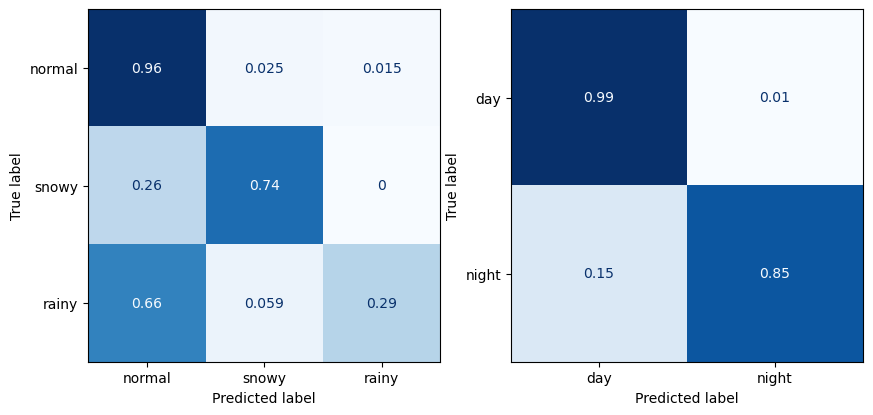

Train Loss : [0.20631] Val Loss : [0.57910] f1 score : [0.81692]


  0%|          | 0/3050 [00:00<?, ?it/s]

  0%|          | 0/763 [00:00<?, ?it/s]

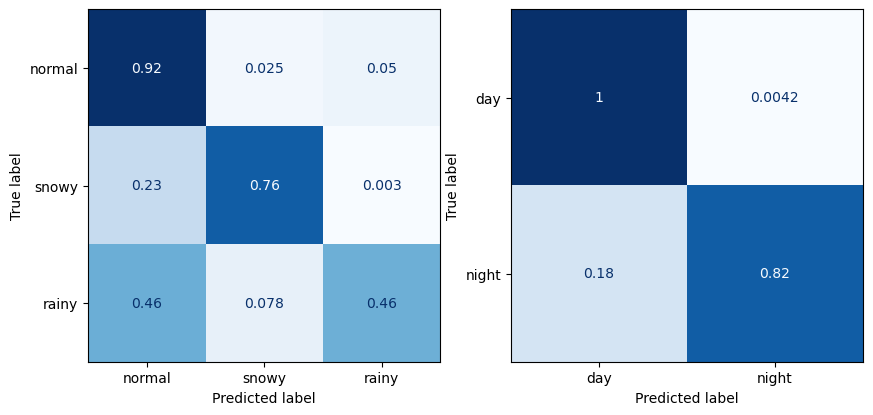

Train Loss : [0.05823] Val Loss : [0.57410] f1 score : [0.83505]
epoch: 1 best val score: 0
detecting outliers...


  0%|          | 0/36600 [00:00<?, ?it/s]

1831 data removed from 36600


  0%|          | 0/2898 [00:00<?, ?it/s]

Train Loss : [0.01333]
psudo labeling...


  0%|          | 0/7582 [00:00<?, ?it/s]

  0%|          | 0/7582 [00:00<?, ?it/s]

  0%|          | 0/763 [00:00<?, ?it/s]

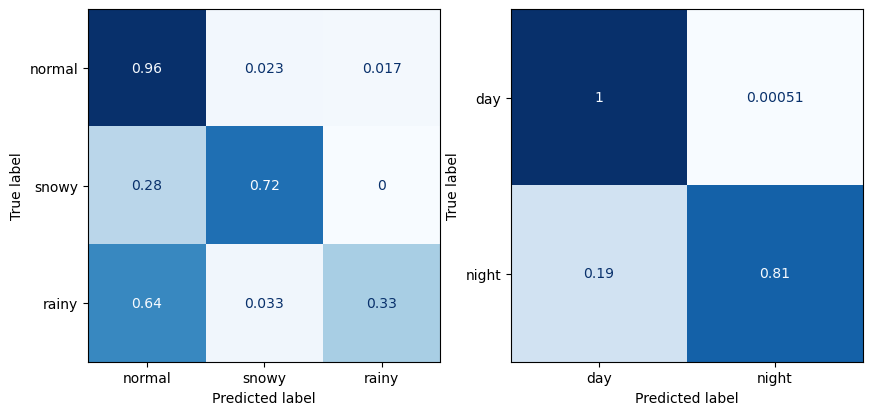

Train Loss : [0.32230] Val Loss : [0.60083] f1 score : [0.82687]
epoch: 2 best val score: 0.8268695753728866
detecting outliers...


  0%|          | 0/36600 [00:00<?, ?it/s]

1831 data removed from 36600


  0%|          | 0/2898 [00:00<?, ?it/s]

Train Loss : [0.02195]
psudo labeling...


  0%|          | 0/7582 [00:00<?, ?it/s]

  0%|          | 0/7582 [00:00<?, ?it/s]

  0%|          | 0/763 [00:00<?, ?it/s]

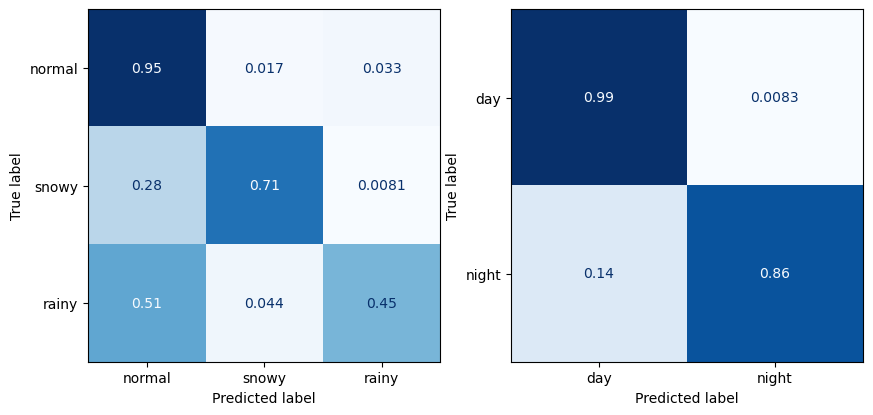

Train Loss : [0.27106] Val Loss : [0.59532] f1 score : [0.84147]
epoch: 3 best val score: 0.8414727950022063
detecting outliers...


  0%|          | 0/36600 [00:00<?, ?it/s]

1831 data removed from 36600


  0%|          | 0/2898 [00:00<?, ?it/s]

Train Loss : [0.01249]
psudo labeling...


  0%|          | 0/7582 [00:00<?, ?it/s]

  0%|          | 0/7582 [00:00<?, ?it/s]

  0%|          | 0/763 [00:00<?, ?it/s]

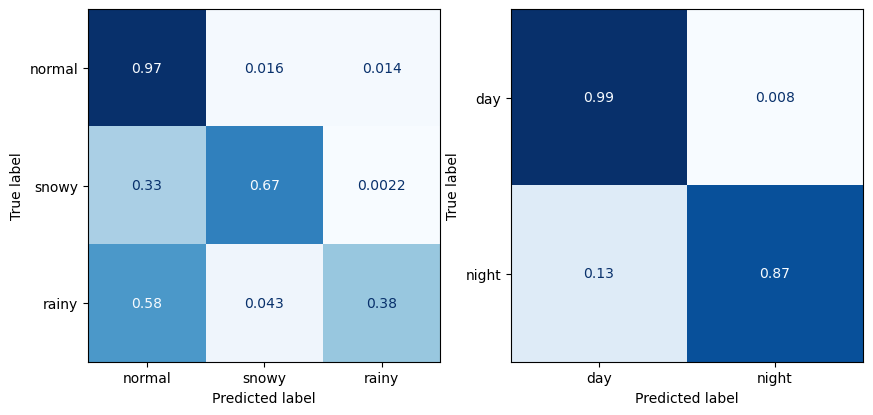

Train Loss : [0.24790] Val Loss : [0.58890] f1 score : [0.83660]
epoch: 4 best val score: 0.8414727950022063
detecting outliers...


  0%|          | 0/36600 [00:00<?, ?it/s]

1831 data removed from 36600


  0%|          | 0/2898 [00:00<?, ?it/s]

Train Loss : [0.00897]
psudo labeling...


  0%|          | 0/7582 [00:00<?, ?it/s]

  0%|          | 0/7582 [00:00<?, ?it/s]

  0%|          | 0/763 [00:00<?, ?it/s]

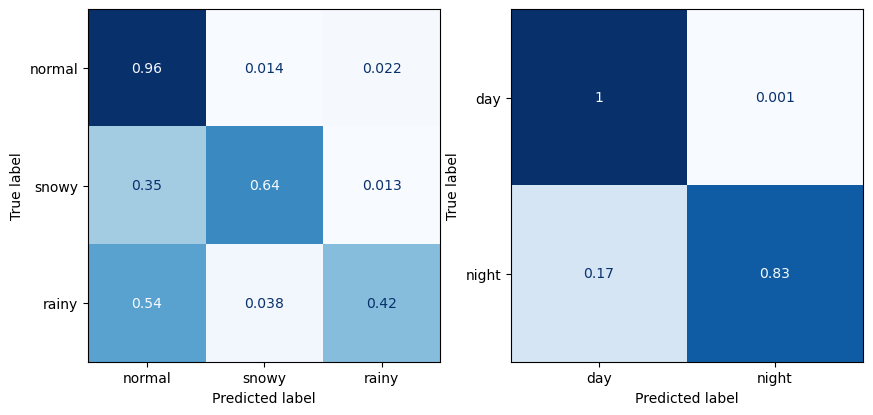

Train Loss : [0.21981] Val Loss : [0.58913] f1 score : [0.83528]
Epoch 00006: reducing learning rate of group 0 to 2.5000e-05.


In [8]:
model = BaseModel()
model.to(device)
model.eval()

optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG['LEARNING_RATE'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=1,threshold_mode='abs',min_lr=1e-8, verbose=True)
best_val_score = 0

train_dataset = util.CustomDataset(train_labeled['path'].values, train_labeled.loc[:, ['weather', 'timing']].values, tfms_train)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=4)
train(model=model, optimizer=optimizer, epochs=2, train_loader=train_loader, val_loader=valid_loader, scheduler=scheduler, device=device)

for epoch in range(1, CFG['EPOCHS'] + 1):
    print('epoch:', epoch, 'best val score:',best_val_score)
    #labeled data 이상치 제거
    print("detecting outliers...")
    train_labeled_updated , train_labeled_outlier = detect_outliers(model, train_labeled, outlier_ratio = CFG['OUTLIER_RATIO'], device=device)
    print(len(train_labeled_outlier), 'data removed from', len(train_labeled))

    # train labeled data
    train_dataset = util.CustomDataset(train_labeled_updated['path'].values, train_labeled_updated.loc[:, ['weather', 'timing']].values, tfms_train)
    train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=4)
    train(model=model, optimizer=optimizer, epochs=1, train_loader=train_loader, val_loader=None, scheduler=scheduler, device=device)

    #psudo labeling
    print("psudo labeling...")
    psudo_labeled = psudo_label(model, pd.concat([train_labeled_outlier, train_unlabeld]), device)

    # train psudo data
    train_path = np.concatenate([train_labeled_outlier['path'].values, train_unlabeld['path'].values])
    train_labels = np.concatenate([psudo_labeled])
    train_dataset = util.CustomDataset(train_path, train_labels, tfms_train)
    train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=4)
    val_score = train(model=model, optimizer=optimizer, epochs=1, train_loader=train_loader, val_loader=valid_loader, scheduler=scheduler, device=device, alpha=0.1)
    if best_val_score < val_score:
        best_val_score = val_score
        torch.save(model.state_dict(), 'model.pth')
